In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import librosa
from librosa import display
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sys
import os


In [ ]:
sys.path.append('/content/drive/MyDrive/ESC-10/')
main_path = '/content/drive/MyDrive/ESC-10'

In [ ]:
from IPython.display import Audio
import IPython

(128, 216)


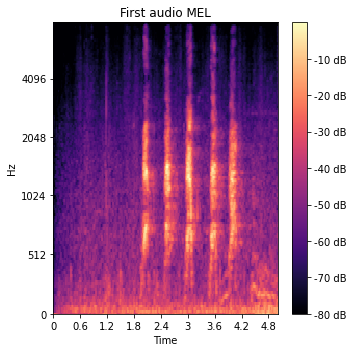

In [ ]:
y1_, sr1_ = librosa.load('/content/drive/MyDrive/ESC-10/001 - Dog bark/1-30226-A.ogg')
plt.figure(figsize=(5, 5))
mel=librosa.feature.mfcc(y=y1_,sr=sr1_)
mel = librosa.feature.melspectrogram(y=y1_, sr=sr1_)
print(mel.shape)
#print(librosa.power_to_db(mel,ref=np.max))
librosa.display.specshow(librosa.power_to_db(mel,ref=np.max),y_axis='mel', fmax=8000,x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title("First audio MEL")
plt.tight_layout()
plt.savefig('/content/sample_data/mel_spectogram.png')

In [ ]:
subdirs = os.listdir(main_path)
print(subdirs)

# 216 Features per frame, <-|--|--|--|--|--------------------------------> 128 X 216

['002 - Rain', '007 - Helicopter', '005 - Clock tick', '003 - Sea waves', '006 - Person sneeze', '008 - Chainsaw', '004 - Baby cry', '009 - Rooster', '010 - Fire crackling', '001 - Dog bark', '.ipynb_checkpoints', 'audiodata.pkl']


In [ ]:
import pickle
from tqdm import tqdm
all_data=[]

for s in tqdm(subdirs):
  
  try:
    cl_tag = int(str(s).split('-')[0])
    
    files = os.listdir(main_path+'/' + str(s))

    for f in files:
      y1_, sr1_ = librosa.load(main_path +'/'+ str(s)+'/'+str(f))
      mfccs = librosa.feature.mfcc(y=y1_, sr=sr1_, n_mfcc=40)
      mfccs_scaled = np.mean(mfccs.T,axis=0)
      features=mfccs_scaled
      labels=int(cl_tag)-1
      all_data.append((features,labels))

  except Exception as e:
    print(e)
with open(main_path+'/audiodata.pkl','wb') as f:
  pickle.dump(all_data,f)


100%|██████████| 12/12 [03:11<00:00, 15.96s/it]


invalid literal for int() with base 10: '.ipynb_checkpoints'
invalid literal for int() with base 10: 'audiodata.pkl'


In [ ]:
import pickle
datafile = open(main_path+"/audiodata.pkl",'rb')
data_list = pickle.load(datafile)
features_=[]
labels_=[]
for elem in data_list:
  features_.append(elem[0])
  labels_.append(elem[1])


In [ ]:
features_=np.array(features_)
labels_=np.array(labels_)
print(features_.shape)
print(labels_.shape)

(400, 40)
(400,)


1-D convolution<br>
<ul>
<li>Kernel moves along one direction</li>
<li>suitable for time series data (2 dimensional)</li>
<li>Conv1D input shape -> (Timesteps x Features)</li>
</ul>
<hr>
2-D convolution<br>
<ul>
<li>Kernel moves along two directions like raster scanning</li>
<li>suitable for image data (3 dimensional)</li>
<li>Conv2D input shape -> (Height x Width x Channels)</li>
</ul>
<hr>
One more thing
3-D convolution<br>
<ul>
<li>Suitable for Movies . Dimension -> (Time x Height x Width x channels)</li>
</ul>


**This Following example is data collected from an accelerometer which a person is wearing on his arm. Data represent the acceleration in all the 3 axes. 1D CNN can perform activity recognition task from accelerometer data, such as if the person is standing, walking, jumping etc. This data has 2 dimensions. The first dimension is time-steps and other is the values of the acceleration in 3 axes.
**
Ref : https://towardsdatascience.com/understanding-1d-and-3d-convolution-neural-network-keras-9d8f76e29610

CNN 1D<br>
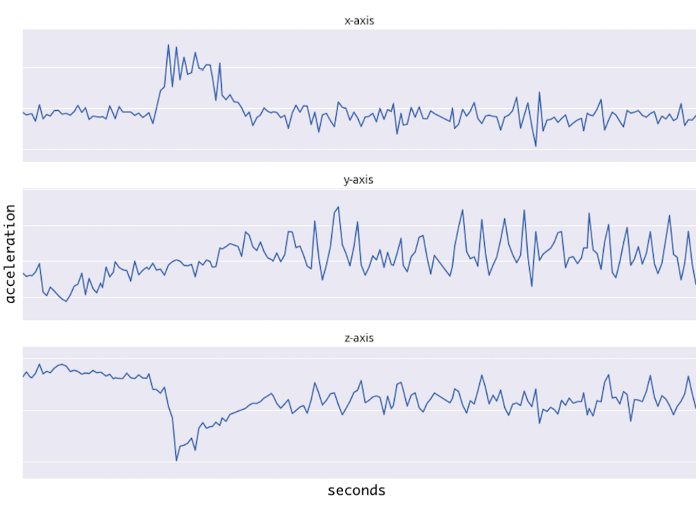
<br>
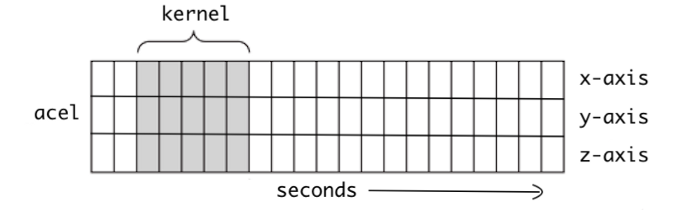

In [ ]:
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
import numpy as np


CNN2D


In [ ]:
from sklearn.preprocessing import StandardScaler as SS
ss=SS()
x = ss.fit_transform(features_)


Our data has shape (Num_samples x features).
<br> Every sample contains 40 Features<br>
Think of it as 40 sequences of 1 feature. 

In [ ]:
train_x = np.expand_dims(features_,axis=2)
print(train_x.shape)
train_y = tf.keras.utils.to_categorical(labels_)
print(train_y.shape)


(400, 40, 1)
(400, 10)


In [ ]:
def my_cnn1d_model(inp_shape, noc = 10):
  model = Sequential()
  # 40 x 1
  model.add(Conv1D(16, 3, strides=1, input_shape=inp_shape))
  model.add(MaxPool1D(pool_size=2))
  
  model.add(Conv1D(32, 3, strides=1))
  model.add(MaxPool1D(pool_size=2))
  model.add(Flatten())
  
  model.add(Dense(units=noc, activation='softmax'))
  return model

In [ ]:
my_model = my_cnn1d_model(train_x[0].shape)
base_learning_rate = 0.0001
my_model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
                      loss=tf.keras.losses.categorical_crossentropy,
                      metrics=['accuracy'])
my_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 38, 16)            64        
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 19, 16)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 17, 32)            1568      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 8, 32)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2570      
Total params: 4,202
Trainable params: 4,202
Non-trainable params: 0
____________________________________________________

In [ ]:
from sklearn.model_selection import train_test_split
x,x_test,y,y_test = train_test_split(train_x, train_y,test_size = 0.2, random_state = 42)
print(x.shape)
print(x_test.shape)
print(y.shape)
print(y_test.shape)

(320, 40, 1)
(80, 40, 1)
(320, 10)
(80, 10)


In [ ]:
history = my_model.fit(x, y, batch_size = 8, validation_data=(x_test,y_test), verbose=True, epochs=20)

Epoch 1/20
40/40 [==============================] - 0s 4ms/step - loss: 0.7012 - accuracy: 0.7781 - val_loss: 1.2324 - val_accuracy: 0.6375
Epoch 2/20
40/40 [==============================] - 0s 4ms/step - loss: 0.6890 - accuracy: 0.8000 - val_loss: 1.2306 - val_accuracy: 0.6500
Epoch 3/20
40/40 [==============================] - 0s 4ms/step - loss: 0.6767 - accuracy: 0.7875 - val_loss: 1.2194 - val_accuracy: 0.6500
Epoch 4/20
40/40 [==============================] - 0s 4ms/step - loss: 0.6654 - accuracy: 0.7937 - val_loss: 1.2050 - val_accuracy: 0.6750
Epoch 5/20
40/40 [==============================] - 0s 4ms/step - loss: 0.6529 - accuracy: 0.8031 - val_loss: 1.1943 - val_accuracy: 0.6750
Epoch 6/20
40/40 [==============================] - 0s 4ms/step - loss: 0.6417 - accuracy: 0.8125 - val_loss: 1.1833 - val_accuracy: 0.6750
Epoch 7/20
40/40 [==============================] - 0s 4ms/step - loss: 0.6334 - accuracy: 0.8156 - val_loss: 1.1922 - val_accuracy: 0.6875
Epoch 8/20
40/40 [==